# RNNによる乗客数の予測

In [13]:
from passengers import Passengers, Line
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import SimpleRNN, LSTM, GRU
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

Using TensorFlow backend.
/Users/toh/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/tensorflow/python/framework/ops.py:875: DeprecationWarning: builtin type EagerTensor has no __module__ attribute
  EagerTensor = c_api.TFE_Py_InitEagerTensor(_EagerTensorBase)
/Users/toh/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/toh/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


In [3]:
file_name = 'data/t091307.xlsx'
line = '田園都市線'
skip_rows = list(range(0, 11)) + list(range(12, 15))
use_cols = list(range(1, 100))
denen = Line(file_name, line, skip_rows, use_cols)

ps = Passengers(line=denen)
display(ps.passengers.head())

/Users/toh/Documents/GitHub/Yokohama-passengers/passengers.py:57: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  df_sheet = df_sheet.convert_objects(convert_numeric=True)


,総数,たまプラーザ,あざみ野,江田,市が尾,藤が丘,青葉台,田奈,長津田,恩田,こどもの国,田園都市線総数
2000-04-01,7898886.0,1038447.0,1557603.0,469799.0,708228.0,433410.0,1634260.0,153682.0,1792431.0,0.0,111026.0,7898886.0
2000-05-01,8148675.0,1051305.0,1612115.0,479847.0,721383.0,437242.0,1677982.0,157103.0,1890997.0,0.0,120701.0,8148675.0
2000-06-01,7950917.0,1045811.0,1593399.0,478787.0,720891.0,428220.0,1615090.0,154114.0,1817606.0,0.0,96999.0,7950917.0
2000-07-01,7669313.0,1014065.0,1546628.0,458828.0,696377.0,418502.0,1543538.0,151814.0,1746031.0,0.0,93530.0,7669313.0
2000-08-01,7292316.0,927861.0,1491875.0,442153.0,664671.0,401388.0,1450025.0,150040.0,1663925.0,8122.0,92256.0,7292316.0


# RNN

In [54]:
df = ps.passengers['総数']

span = 12
data = []
target = []

for i in range(len(df) - span):
    data.append(df[i : i + span])
    target.append(df[i + span])
    
X = np.array(data).reshape(len(data), span, 1)
Y = np.array(target).reshape(len(data), 1)
X = X/10000000
Y = Y/10000000

In [55]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=0.1)

In [56]:
n_in = len(X[0][0]) 
n_hidden = 10
n_out = len(Y[0])

def weight_variable(shape, name=None):
    return np.random.normal(scale=.01, size=shape)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

model = Sequential()
model.add(GRU(n_hidden,
              input_shape=(span, n_in)
             ))
model.add(Dense(n_out))
model.add(Activation('linear'))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

/Users/toh/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


In [57]:
epochs = 500
batch_size = 6

hist = model.fit(X_train, Y_train,
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_validation, Y_validation),
                 callbacks=[early_stopping])

/Users/toh/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


Train on 166 samples, validate on 19 samples
Epoch 1/500
166/166 [==============================] - 2s 10ms/step - loss: 0.7263 - val_loss: 0.4413
Epoch 2/500
166/166 [==============================] - 0s 2ms/step - loss: 0.2659 - val_loss: 0.1114
Epoch 3/500
166/166 [==============================] - 0s 1ms/step - loss: 0.0450 - val_loss: 0.0056
Epoch 4/500
166/166 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 5/500
166/166 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 6/500
166/166 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 7/500
166/166 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 8/500
166/166 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 9/500
166/166 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 10/500
166/166 [=======================

Epoch 81/500
166/166 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 82/500
166/166 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 83/500
166/166 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 84/500
166/166 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 85/500
166/166 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 86/500
166/166 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 87/500
166/166 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 88/500
166/166 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 89/500
166/166 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 90/500
166/166 [==============================] - 0s 2ms/step - loss: 0.0015

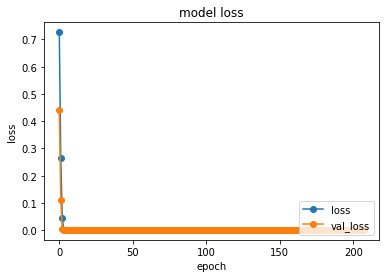

In [58]:
def plot_history(history):
    plt.plot(history.history['loss'],"o-",label="loss",)
    plt.plot(history.history['val_loss'],"o-",label="val_loss")
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='lower right')
    plt.show()

plot_history(hist)  

In [59]:
def forecast(model, x, n, span):
    model.reset_states()
    Y = []
    x_tmp = x
    for i in range(n):
        x_tmp = x_tmp.reshape(1, span, 1)
        y = model.predict(x_tmp)
        Y.append(y)

        x_tmp = x_tmp.reshape(span, 1)
        x_tmp = np.vstack((x_tmp, y))
        x_tmp = np.delete(x_tmp, 0, 0)
        
    model.reset_states()
    return Y

In [60]:
Y_pred = forecast(model, X_test[0], len(X_test), span)

In [61]:
Y_test_pred = model.predict(X_test)

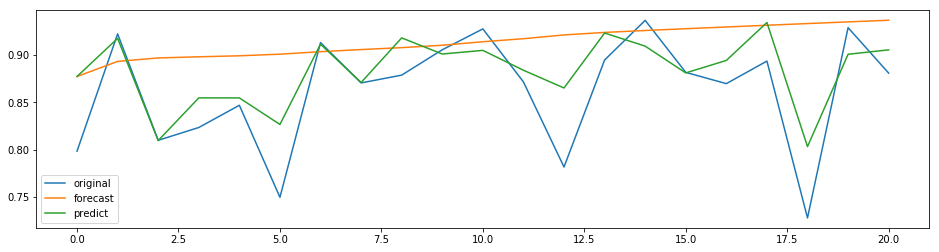

In [63]:
plt.figure(figsize=(16, 4))
plt.plot(Y_test, label='original')
plt.plot(np.array([Y_pred]).reshape(len(Y_pred),1), label='forecast')
plt.plot(Y_test_pred, label='predict')
plt.legend(loc='best')
plt.show()

* うまくいっていないが時間がないので、後で確認